## Práctica 3 Medición de Riesgos QFB - Cópulas

Autores: Guillem Borràs, Gonzalo Moll 

Profesor: Ángel León - aleonvalle@gmail.com , aleon@ua.es


In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import triang, norm, t, skew, kurtosis
from scipy import integrate, optimize
from utils_copulas import (tri_pdf, tri_rvs, gaussian_copula_uv,
                            F1_ppf, F2_ppf,
                            portfolio_returns, var_left_tail, normal_fit_pdf,
                            clayton_quantile_curve_r2, clayton_returns_from_pdfI,
                            t_copula_uv, solve_u2_for_quantile,
                            simulate_nm_copula, inv_cdf_r1, pdf_r2,
                            pdf_r1, pdf_joint, cond_exp_r1_given_r2,
                            cdf_cond_r1_given_r2, inv_cdf_r2, cdf_r1,
                            conditional_copula_val, inverse_triangular, 
                            simulate_truncated
                            )


---

#### Exercise 1

Consider the following points: $A = (1,0)$, $B = (5,0)$ and $C = \left( 3, \frac{1}{2} \right)$. Let $\overline{AC}$ be the equation of the line passing through the points $A$ and $C$, and $\overline{BC}$ the equation of the line passing through $B$ and $C$.

i) 

Find the lines $\overline{AC}$ and $\overline{BC}$. Obtain the expression for the function $f(x)$ where $f(x) = \overline{AC}$ for $1 \le x \le 3$, $f(x) = \overline{BC}$ for $3 < x \le 5$, and $f(x) = 0$ in other cases.

ii)

Plot the graph of $f(x)$ and verify that it is a pdf.

> #### Exercise 1 Solution

### i)

Slope of $\overline{AC}$:
$$
m_{AC}=\frac{\frac12-0}{3-1}=\frac{1/2}{2}=\frac14
$$
Equation:
$$
\overline{AC}: \; y=\frac14(x-1)=\frac{x-1}{4}
$$

Slope of $\overline{BC}$:
$$
m_{BC}=\frac{\frac12-0}{3-5}=\frac{1/2}{-2}=-\frac14
$$
Equation:
$$
\overline{BC}: \; y=-\frac14(x-5)=\frac{5-x}{4}
$$

Therefore,
$$
f(x)=
\begin{cases}
\frac{x-1}{4}, & 1\le x\le 3,\\
\frac{5-x}{4}, & 3<x\le 5,\\
0, & \text{otherwise}.
\end{cases}
$$


### ii)

Non-negativity: $f(x)\ge 0$ on $[1,5]$ and $f(x)=0$ otherwise.

Integral:
$$
\int_{1}^{3}\frac{x-1}{4}\,dx+\int_{3}^{5}\frac{5-x}{4}\,dx
$$

First term:
$$
\frac14\left[\frac{x^2}{2}-x\right]_{1}^{3}=\frac14(2)=\frac12
$$

Second term:
$$
\frac14\left[5x-\frac{x^2}{2}\right]_{3}^{5}=\frac14(2)=\frac12
$$

Total area:
$$
\frac12+\frac12=1
$$

Hence, $f(x)$ is a pdf.


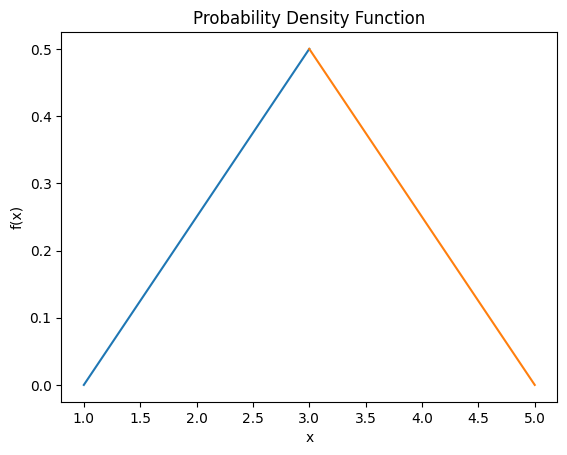

In [2]:
x1 = np.linspace(1,3,200)
x2 = np.linspace(3,5,200)

y1 = (x1-1)/4
y2 = (5-x2)/4

plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Probability Density Function")
plt.show()


---

#### Exercise 2

The previous exercise is related to the **Triangular (Tr)** distribution, denoted as  
$X \sim \mathrm{Tr}(a,b,c)$, where $a < c < b$, with the points:

- $A = (a,0)$  
- $B = (b,0)$  
- $C = \left(c,\dfrac{2}{b-a}\right)$

Answer the following questions:

i)  

Obtain $f(x)$ and $F(x)$, corresponding to the **pdf** and **cdf** of  
$X \sim \mathrm{Tr}(a,b,c)$.

ii)  

Compute  
$$
\mu_X = \mathbb{E}(X)
\quad \text{and} \quad
\sigma_X^2 = \mathrm{Var}(X).
$$

iii)  

Find the expression of  
$$
X = F^{-1}(U),
$$
where $U \sim \mathcal{U}(0,1)$.

Generate **10,000 draws** of $X \sim \mathrm{Tr}(1,5,3)$.  
Plot the graph of $f(x)$, already obtained in **Exercise 1**, together with the **histogram of the simulated draws**.


> #### Exercise 2 Solution

Para $X \sim \mathrm{Tr}(a,b,c)$ con $a<c<b$, la densidad es triangular con soporte $[a,b]$ y altura máxima en $x=c$. La función de densidad $f(x)$ es lineal creciente en $[a,c]$ y lineal decreciente en $[c,b]$, y vale cero fuera del soporte:

$$
f(x)=
\begin{cases}
0, & x<a,\\[4pt]
\dfrac{2(x-a)}{(b-a)(c-a)}, & a\le x\le c,\\[8pt]
\dfrac{2(b-x)}{(b-a)(b-c)}, & c\le x\le b,\\[8pt]
0, & x>b.
\end{cases}
$$

Integrando por tramos (integrales inmediatas) se obtiene la función de distribución acumulada $F(x)$. Para $x\le a$ es $0$ y para $x\ge b$ es $1$. En los tramos intermedios queda:

$$
F(x)=
\begin{cases}
0, & x\le a,\\[6pt]
\dfrac{(x-a)^2}{(b-a)(c-a)}, & a\le x\le c,\\[10pt]
1-\dfrac{(b-x)^2}{(b-a)(b-c)}, & c\le x\le b,\\[10pt]
1, & x\ge b.
\end{cases}
$$

A continuación calculamos $\mu_X=\mathbb{E}[X]$ y $\mathbb{E}[X^2]$. Partimos de

$$
\mathbb{E}[X]=\int_{-\infty}^{\infty} x f(x)\,dx
=\int_a^c x\,\frac{2(x-a)}{(b-a)(c-a)}\,dx+\int_c^b x\,\frac{2(b-x)}{(b-a)(b-c)}\,dx.
$$

Para el tramo izquierdo:

$$
\int_a^c x\,\frac{2(x-a)}{(b-a)(c-a)}\,dx
=\frac{2}{(b-a)(c-a)}\int_a^c (x^2-ax)\,dx
$$

$$
=\frac{2}{(b-a)(c-a)}\left[\frac{x^3}{3}-a\frac{x^2}{2}\right]_a^c
=\frac{2}{(b-a)(c-a)}\left(\frac{c^3-a^3}{3}-a\frac{c^2-a^2}{2}\right).
$$

Para el tramo derecho:

$$
\int_c^b x\,\frac{2(b-x)}{(b-a)(b-c)}\,dx
=\frac{2}{(b-a)(b-c)}\int_c^b (bx-x^2)\,dx
$$

$$
=\frac{2}{(b-a)(b-c)}\left[b\frac{x^2}{2}-\frac{x^3}{3}\right]_c^b
=\frac{2}{(b-a)(b-c)}\left(b\frac{b^2-c^2}{2}-\frac{b^3-c^3}{3}\right).
$$

Sumando ambos términos y simplificando algebraicamente se obtiene el resultado conocido:

$$
\mu_X=\mathbb{E}[X]=\frac{a+b+c}{3}.
$$

De manera análoga, para el segundo momento:

$$
\mathbb{E}[X^2]=\int_{-\infty}^{\infty} x^2 f(x)\,dx
=\int_a^c x^2\,\frac{2(x-a)}{(b-a)(c-a)}\,dx+\int_c^b x^2\,\frac{2(b-x)}{(b-a)(b-c)}\,dx.
$$

Tramo izquierdo:

$$
\int_a^c x^2\,\frac{2(x-a)}{(b-a)(c-a)}\,dx
=\frac{2}{(b-a)(c-a)}\int_a^c (x^3-a x^2)\,dx
$$

$$
=\frac{2}{(b-a)(c-a)}\left[\frac{x^4}{4}-a\frac{x^3}{3}\right]_a^c
=\frac{2}{(b-a)(c-a)}\left(\frac{c^4-a^4}{4}-a\frac{c^3-a^3}{3}\right).
$$

Tramo derecho:

$$
\int_c^b x^2\,\frac{2(b-x)}{(b-a)(b-c)}\,dx
=\frac{2}{(b-a)(b-c)}\int_c^b (b x^2-x^3)\,dx
$$

$$
=\frac{2}{(b-a)(b-c)}\left[b\frac{x^3}{3}-\frac{x^4}{4}\right]_c^b
=\frac{2}{(b-a)(b-c)}\left(b\frac{b^3-c^3}{3}-\frac{b^4-c^4}{4}\right).
$$

Sumando y simplificando se obtiene:

$$
\mathbb{E}[X^2]=\frac{a^2+b^2+c^2+ab+ac+bc}{6}.
$$

Finalmente,

$$
\sigma_X^2=\mathrm{Var}(X)=\mathbb{E}[X^2]-\mathbb{E}[X]^2
=\frac{a^2+b^2+c^2+ab+ac+bc}{6}-\left(\frac{a+b+c}{3}\right)^2
=\frac{a^2+b^2+c^2-ab-ac-bc}{18}.
$$

Para simular por transformada inversa, tomamos $U\sim \mathcal{U}(0,1)$ y resolvemos $U=F(x)$ en cada tramo. Primero, el punto de cambio en el dominio de $U$ es $F(c)$:

$$
F(c)=\frac{(c-a)^2}{(b-a)(c-a)}=\frac{c-a}{b-a}.
$$

Definiendo $p=\dfrac{c-a}{b-a}$, la inversa $F^{-1}(u)$ queda:

$$
F^{-1}(u)=
\begin{cases}
a+\sqrt{u\,(b-a)(c-a)}, & 0\le u\le p,\\[8pt]
b-\sqrt{(1-u)\,(b-a)(b-c)}, & p<u\le 1.
\end{cases}
$$

En el caso concreto $X\sim \mathrm{Tr}(1,5,3)$ se tiene $a=1$, $b=5$, $c=3$ y por tanto $p=\dfrac{c-a}{b-a}=\dfrac{2}{4}=\dfrac{1}{2}$. La inversa se simplifica a:

$$
F^{-1}(u)=
\begin{cases}
1+\sqrt{8u}, & 0\le u\le \frac{1}{2},\\[6pt]
5-\sqrt{8(1-u)}, & \frac{1}{2}<u\le 1.
\end{cases}
$$

Con esto, para generar 10,000 muestras basta tomar $u_1,\dots,u_{10000}\stackrel{iid}{\sim}\mathcal{U}(0,1)$ y transformar $x_k=F^{-1}(u_k)$. Para comparar con la teoría, se superpone el histograma de $\{x_k\}$ con la densidad:

$$
f(x)=
\begin{cases}
\dfrac{x-1}{4}, & 1\le x\le 3,\\[6pt]
\dfrac{5-x}{4}, & 3\le x\le 5,\\[6pt]
0, & \text{en otro caso}.
\end{cases}
$$

Si el número de muestras es grande, el histograma debería aproximar bien esta forma triangular, con máximo en $x=3$ y base entre $1$ y $5$.

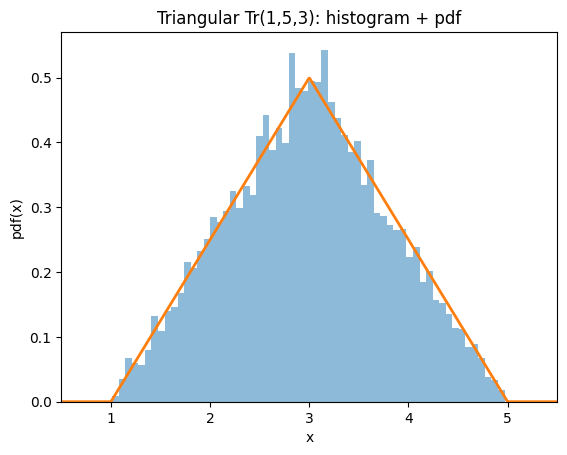

In [3]:
a, b, c = 1.0, 5.0, 3.0
n = 10_000
seed = 123

x = tri_rvs(a, b, c, size=n, seed=seed)

grid = np.linspace(a - 0.5, b + 0.5, 600)
pdf = tri_pdf(grid, a, b, c)

plt.hist(x, bins=60, density=True, alpha=0.5)
plt.plot(grid, pdf, linewidth=2)
plt.xlim(a - 0.5, b + 0.5)
plt.title("Triangular Tr(1,5,3): histogram + pdf")
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.show()


---

#### Exercise 3.
Consider the random variables of stock returns $R_1$ and $R_2$ with bivariate pdf:

$$f(r_1, r_2) = \begin{cases} \alpha + \beta r_1 + \gamma r_2, & -1 \le r_1 \le 2, \ -2 \le r_2 \le 2.5 \\ 0, & \text{elsewhere} \end{cases} \quad \text{(I)}$$

where $\alpha = 0.0642, \beta = 0.0049, \gamma = 0.0296$. Given some results from the problem set with title "Introduction to bivariate copulas", answer the questions:

i)

Find $E(R_1 \mid R_1 \le F_1^{-1}(p))$ with $p = 0.01$. Obtain $E(R_1 \mid R_2 = r_2) = \int_{-1}^2 r_1 f(r_1 \mid r_2) dr_1$, and also plot its graph.

ii)

Obtain $C^1(u_1 \mid u_2)$, which is the conditional copula $C(u_1 \mid u_2) = P(U_1 \le u_1 \mid U_2 = u_2)$ from the bivariate pdf (I).

iii)

Generate $N = 10,000$ draws $\{(v_{1,k}, v_{2,k})\}_{k=1}^N$ of independent $V_i \sim U(0,1)$ where $i=1,2$ to obtain $N$ draws $\{(u_{1,k}, u_{2,k})\}_{k=1}^N$ of dependent $U_i \sim U(0,1)$ such that $v_{1,k} = C^1(u_{1,k} \mid v_{2,k})$ in the previous section and $u_{2,k} = v_{2,k}$.

Make the scatterplots for the simulated independent and dependent $U(0,1)$ points.

> #### Exercise 3 Solution

### i)

In [4]:
alpha, beta, gamma = 0.0642, 0.0049, 0.0296
r1_min, r1_max = -1, 2
r2_min, r2_max = -2, 2.5

Límite (VaR al 1%): -0.9667
E[R1 | R1 <= VaR]: -0.9834


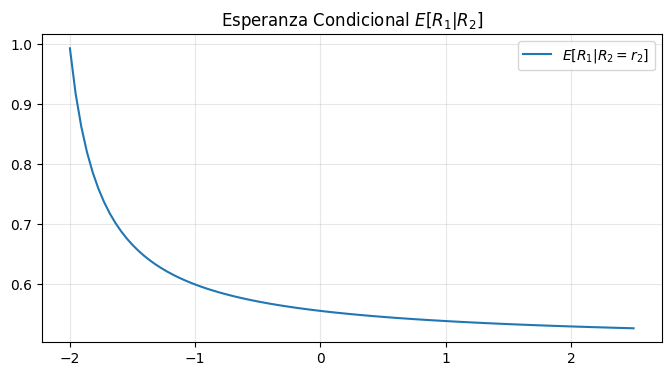

In [5]:
p = 0.01
r1_limit = inv_cdf_r1(p)
integral_ES, _ = integrate.quad(lambda r: r * pdf_r1(r), r1_min, r1_limit)
expected_shortfall = integral_ES / p
print(f"Límite (VaR al 1%): {r1_limit:.4f}")
print(f"E[R1 | R1 <= VaR]: {expected_shortfall:.4f}")

r2_vals = np.linspace(r2_min, r2_max, 100)
e_r1_vals = [cond_exp_r1_given_r2(r) for r in r2_vals]

plt.figure(figsize=(8, 4))
plt.plot(r2_vals, e_r1_vals, label=r'$E[R_1 | R_2 = r_2]$')
plt.title(r'Esperanza Condicional $E[R_1 | R_2]$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### ii)

**Objetivo:** Obtener la cópula condicional $C^1(u_1|u_2)$, definida como $P(U_1 \le u_1 | U_2 = u_2)$, a partir de la función de densidad de probabilidad (PDF) bivariada dada.

Dada la PDF conjunta de los retornos $R_1$ y $R_2$:

$$f(r_1, r_2) = \alpha + \beta r_1 + \gamma r_2$$

Con dominio:
* $r_1 \in [-1, 2]$
* $r_2 \in [-2, 2.5]$

Sabemos que las variables uniformes están relacionadas con los retornos mediante sus funciones de distribución acumulada (CDF) marginales:
$$U_1 = F_{R_1}(R_1) \quad \text{y} \quad U_2 = F_{R_2}(R_2)$$

Por lo tanto, la cópula condicional se puede expresar en términos de las variables originales como:
$$C^1(u_1|u_2) = P(R_1 \le F_{R_1}^{-1}(u_1) \mid R_2 = F_{R_2}^{-1}(u_2))$$

Para resolver esto, necesitamos:
1.  La densidad marginal $f_{R_2}(r_2)$.
2.  La densidad condicional $f(r_1 | r_2)$.
3.  La CDF condicional $F(r_1 | r_2)$.

Obtención de la Marginal de $R_2$

La densidad marginal de $R_2$ se obtiene integrando la conjunta sobre todo el dominio de $R_1$ ($[-1, 2]$):

$$f_{R_2}(r_2) = \int_{-1}^{2} (\alpha + \beta r_1 + \gamma r_2) \, dr_1$$

Resolviendo la integral:
$$f_{R_2}(r_2) = \left[ \alpha r_1 + \frac{\beta}{2} r_1^2 + \gamma r_2 r_1 \right]_{-1}^{2}$$

$$= \left( 2\alpha + \frac{\beta}{2}(4) + 2\gamma r_2 \right) - \left( -\alpha + \frac{\beta}{2}(1) - \gamma r_2 \right)$$

$$= 3\alpha + \frac{3}{2}\beta + 3\gamma r_2$$

Obtención de la Densidad Condicional $f(r_1 | r_2)$

Usando la definición de probabilidad condicional $f(r_1 | r_2) = \frac{f(r_1, r_2)}{f_{R_2}(r_2)}$:

$$f(r_1 | r_2) = \frac{\alpha + \beta r_1 + \gamma r_2}{3\alpha + 1.5\beta + 3\gamma r_2}$$

Obtención de la Cópula Condicional $C^1(u_1 | u_2)$

La cópula condicional es equivalente a la CDF condicional de $R_1$ dado $R_2$. Integramos la densidad condicional desde el límite inferior de $R_1$ (que es $-1$) hasta un valor $r_1$:

$$F(r_1 | r_2) = \int_{-1}^{r_1} f(t | r_2) \, dt = \int_{-1}^{r_1} \frac{\alpha + \beta t + \gamma r_2}{3\alpha + 1.5\beta + 3\gamma r_2} \, dt$$

Dado que el denominador no depende de $t$, lo sacamos como constante $K(r_2)$:
$$K(r_2) = \frac{1}{3\alpha + 1.5\beta + 3\gamma r_2}$$

Integramos el numerador:
$$\int_{-1}^{r_1} (\alpha + \gamma r_2 + \beta t) \, dt = \left[ (\alpha + \gamma r_2)t + \frac{\beta}{2}t^2 \right]_{-1}^{r_1}$$

$$= \left( (\alpha + \gamma r_2)r_1 + \frac{\beta}{2}r_1^2 \right) - \left( (\alpha + \gamma r_2)(-1) + \frac{\beta}{2}(-1)^2 \right)$$

$$= (\alpha + \gamma r_2)(r_1 + 1) + \frac{\beta}{2}(r_1^2 - 1)$$

Finalmente, la expresión analítica para la cópula condicional es:

$$C^1(u_1|u_2) = \frac{(\alpha + \gamma r_2)(r_1 + 1) + \frac{\beta}{2}(r_1^2 - 1)}{3\alpha + 1.5\beta + 3\gamma r_2}$$


In [6]:
# Ejemplo de uso:
print(f"Valor de muestra C(0.5 | 0.5): {conditional_copula_val(0.5, 0.5):.4f}")


Valor de muestra C(0.5 | 0.5): 0.5065


### iii)

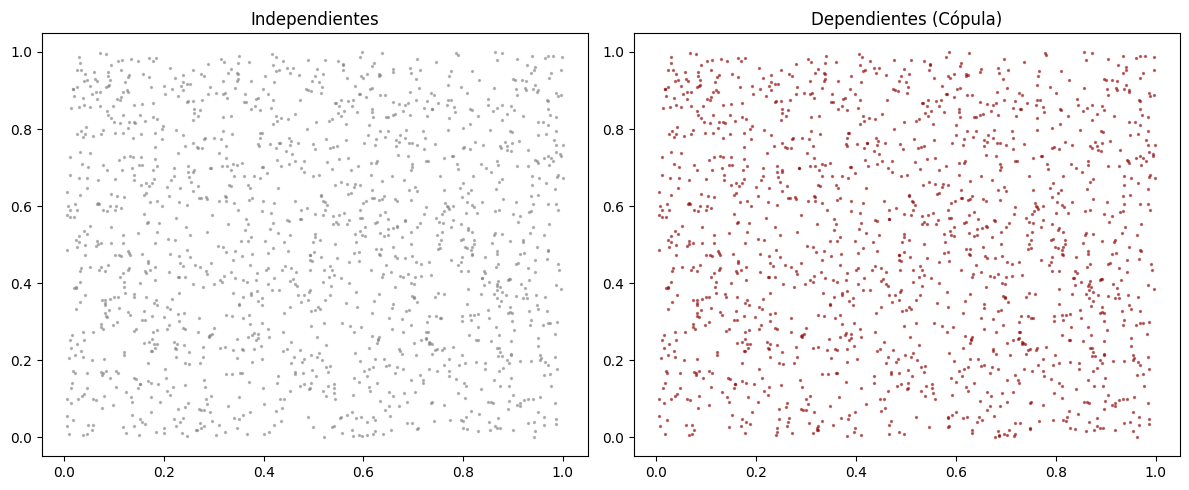

In [7]:
np.random.seed(42)
N = 10000
V1 = np.random.uniform(0, 1, N)
V2 = np.random.uniform(0, 1, N)
U1_dep = np.zeros(N)
U2_dep = V2 

for k in range(N):
    # Paso A: Generar R2 desde V2
    r2_val = inv_cdf_r2(V2[k])
    
    # Paso B: Generar R1 dado R2
    target = V1[k]
    
    # Función objetivo local para brentq
    def obj_func(r):
        return cdf_cond_r1_given_r2(r, r2_val) - target
    
    # Verificación de bordes para evitar ValueError en el bucle
    f_min = obj_func(r1_min)
    f_max = obj_func(r1_max)
    
    if f_min > 0: r1_val = r1_min
    elif f_max < 0: r1_val = r1_max
    else:
        try:
            r1_val = optimize.brentq(obj_func, r1_min, r1_max)
        except ValueError:
            r1_val = r1_min # Fallback en caso extremo
            
    U1_dep[k] = cdf_r1(r1_val) # Convertir al espacio Cópula (0,1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(V1[:1500], V2[:1500], s=2, alpha=0.5, color='gray')
ax[0].set_title(r'Independientes')
ax[1].scatter(U1_dep[:1500], U2_dep[:1500], s=2, alpha=0.5, color='darkred')
ax[1].set_title(r'Dependientes (Cópula)')
plt.tight_layout()
plt.show()

### iv)

In [8]:
a1, b1, mu1 = -1, 2, 0.55
c1_mode = 3 * mu1 - b1 - a1  # c = 1.65 - 2 - (-1) = 0.65

# R2 (Tr2):
a2, b2, mu2 = -2, 2.5, 0.93
c2_mode = 3 * mu2 - b2 - a2  # c = 2.79 - 2.5 - (-2) = 2.29

# Generar muestras R_tri usando los U_dep (Inverse Transform Sampling)
# Scipy triang params: c_shape = (mode - min) / (max - min), loc = min, scale = max - min
shape1 = (c1_mode - a1) / (b1 - a1)
R1_tri = triang.ppf(U1_dep, c=shape1, loc=a1, scale=b1-a1)

shape2 = (c2_mode - a2) / (b2 - a2)
R2_tri = triang.ppf(U2_dep, c=shape2, loc=a2, scale=b2-a2)

# Construir Portfolio A
w1, w2 = 0.25, 0.75
Port_A = w1 * R1_tri + w2 * R2_tri

# Estadísticas
mean_A = np.mean(Port_A)
std_A = np.std(Port_A)
var_1_A = np.percentile(Port_A, 1)
var_5_A = np.percentile(Port_A, 5)

print(f"Parámetros Triangulares calculados -> c1: {c1_mode:.2f}, c2: {c2_mode:.2f}")
print(f"Portfolio A Mean: {mean_A:.4f}")
print(f"Portfolio A Std:  {std_A:.4f}")
print(f"VaR 1% (quantile): {var_1_A:.4f}")
print(f"VaR 5% (quantile): {var_5_A:.4f}")

Parámetros Triangulares calculados -> c1: 0.65, c2: 2.29
Portfolio A Mean: 0.8430
Portfolio A Std:  0.7871
VaR 1% (quantile): -1.0485
VaR 5% (quantile): -0.6261


### v)

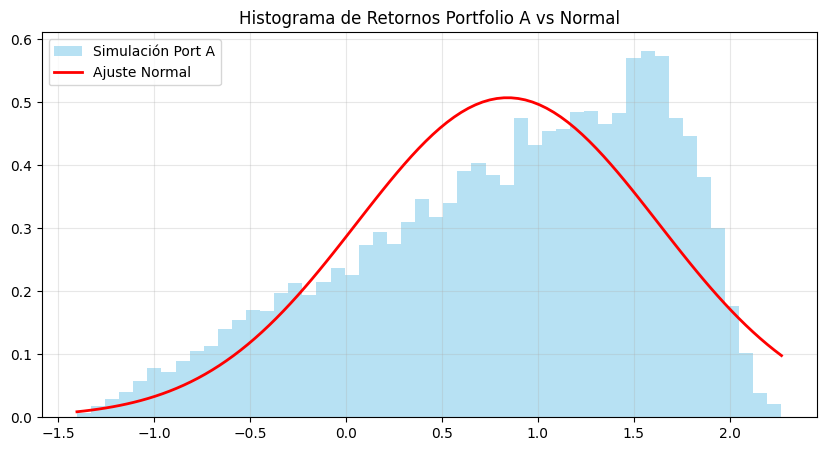

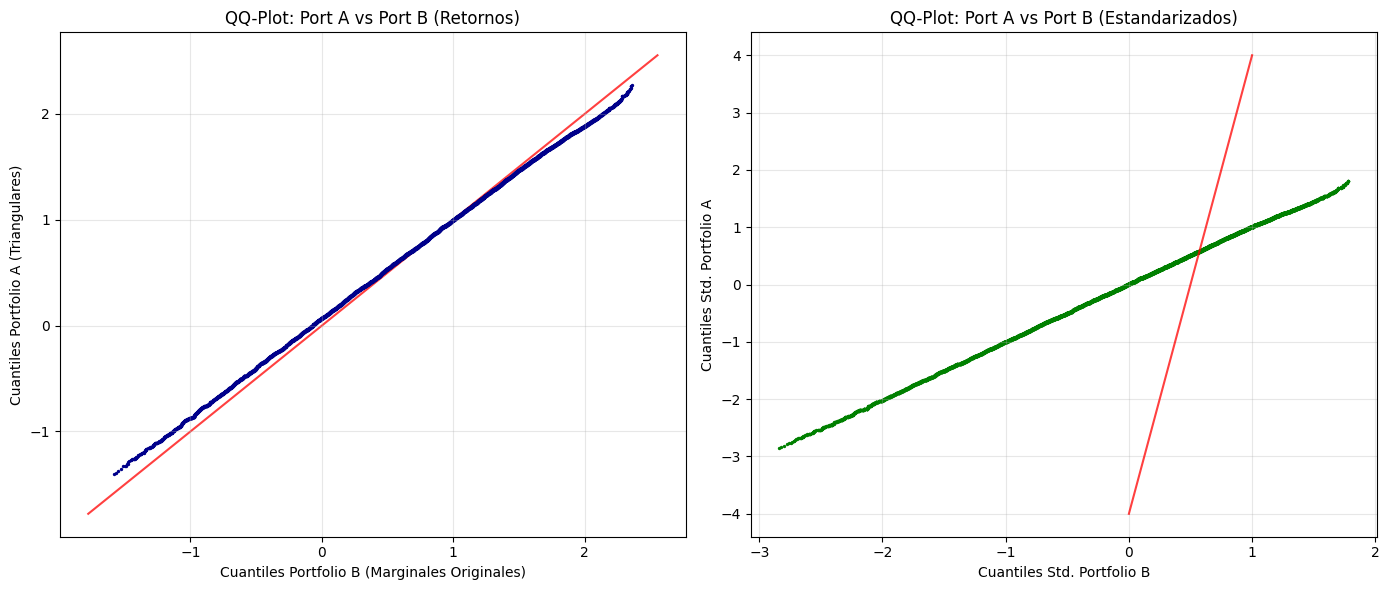

In [9]:
# Construir Portfolio B (usando R originales simulados anteriormente)
# Necesitamos convertir U1_dep y U2_dep de vuelta a R_original usando las marginales del PDF (I)
# Nota: En el paso iii del código anterior, ya calculamos r1_val intermedios, 
# pero para ser vectorizado rápido, usamos inv_cdf sobre los U generados.
R1_orig = np.array([inv_cdf_r1(u) for u in U1_dep]) 
R2_orig = np.array([inv_cdf_r2(u) for u in U2_dep])

Port_B = w1 * R1_orig + w2 * R2_orig

# Plot Histogram + Normal Fit (Portfolio A)
plt.figure(figsize=(10, 5))
plt.hist(Port_A, bins=50, density=True, alpha=0.6, color='skyblue', label='Simulación Port A')

# Ajuste Normal
mu_fit, std_fit = norm.fit(Port_A)
x_axis = np.linspace(min(Port_A), max(Port_A), 100)
plt.plot(x_axis, norm.pdf(x_axis, mu_fit, std_fit), 'r-', lw=2, label='Ajuste Normal')
plt.title('Histograma de Retornos Portfolio A vs Normal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# QQ-Plot: Portfolio A vs Portfolio B
# Ordenamos ambos retornos para comparar cuantiles
sorted_A = np.sort(Port_A)
sorted_B = np.sort(Port_B)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# QQ-Plot Directo (Returns)
ax[0].scatter(sorted_B, sorted_A, s=2, color='darkblue')
# Línea 45 grados de referencia (min/max global)
lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),  
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]
ax[0].plot(lims, lims, 'r-', alpha=0.75, zorder=0)
ax[0].set_xlabel('Cuantiles Portfolio B (Marginales Originales)')
ax[0].set_ylabel('Cuantiles Portfolio A (Triangulares)')
ax[0].set_title('QQ-Plot: Port A vs Port B (Retornos)')
ax[0].grid(True, alpha=0.3)

# QQ-Plot Estandarizado
# Estandarizamos (X - mu) / sigma
std_Port_A = (sorted_A - np.mean(sorted_A)) / np.std(sorted_A)
std_Port_B = (sorted_B - np.mean(sorted_B)) / np.std(sorted_B)

ax[1].scatter(std_Port_B, std_Port_A, s=2, color='green')
ax[1].plot([-4, 4], 'r-', alpha=0.75) # Línea ref estandarizada
ax[1].set_xlabel('Cuantiles Std. Portfolio B')
ax[1].set_ylabel('Cuantiles Std. Portfolio A')
ax[1].set_title('QQ-Plot: Port A vs Port B (Estandarizados)')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

#### Exercise 4.

Consider the random variables of stock returns $R_1$ and $R_2$ with bivariate pdf given by

$$
f(r_1,r_2)=c\!\left(F_1(r_1),F_2(r_2)\right) f_1(r_1) f_2(r_2),
$$

such that the marginal distributions are those from the bivariate pdf (I).

Obtain $f(r_1,r_2)$ under alternative bivariate copulas in the following cases:

i) The bivariate standardized Gaussian (G) copula pdf with $\rho$ as the correlation coefficient is given by

$$
c^{G}(u_1,u_2;\rho)
=
|\Psi|^{-1/2}
\exp\!\left(
-\frac{1}{2}\,\eta'(\Psi^{-1}-I_2)\eta
\right),
$$

where

$$
\eta=\bigl(\Phi^{-1}(u_1),\Phi^{-1}(u_2)\bigr)',
$$

$\Psi$ is the correlation matrix, $I_2$ is the identity matrix of order $2$, and $\Phi^{-1}(\cdot)$ is the inverse of the $N(0,1)$ cdf.

ii) The bivariate FGM copula pdf is given by

$$
c^{FGM}(u_1,u_2;\lambda)
=
1+\lambda(2u_1-1)(2u_2-1),
\qquad
\lambda\in[-1,1].
$$

> #### Exercise 4 Solution

i)
Sea $(R_1,R_2)$ un par con marginales continuas $F_1,F_2$ y densidades $f_1,f_2$. Definimos las transformaciones

$$
U_1 = F_1(R_1),\qquad U_2 = F_2(R_2),
$$

de modo que $U_1,U_2\sim \mathcal U(0,1)$ y su densidad conjunta viene dada por una cópula con densidad $c(u_1,u_2)$:

$$
f_{U_1,U_2}(u_1,u_2)=c(u_1,u_2).
$$

La densidad conjunta de $(R_1,R_2)$ se obtiene por cambio de variable usando que $u_1=F_1(r_1)$, $u_2=F_2(r_2)$ y que el jacobiano es

$$
\left|\frac{\partial(u_1,u_2)}{\partial(r_1,r_2)}\right|
=
\begin{vmatrix}
\frac{\partial F_1(r_1)}{\partial r_1} & 0\\
0 & \frac{\partial F_2(r_2)}{\partial r_2}
\end{vmatrix}
=
f_1(r_1)\,f_2(r_2).
$$

Por tanto,

$$
f_{R_1,R_2}(r_1,r_2)
=
f_{U_1,U_2}\!\left(F_1(r_1),F_2(r_2)\right)\,
\left|\frac{\partial(u_1,u_2)}{\partial(r_1,r_2)}\right|
=
c\!\left(F_1(r_1),F_2(r_2)\right)f_1(r_1)f_2(r_2).
$$

A continuación se particulariza $c$ para cada familia de cópulas pedida.

ii)

En la cópula Gaussiana bivariante, fijamos una matriz de correlación

$$
\Psi=
\begin{pmatrix}
1 & \rho\\
\rho & 1
\end{pmatrix},
\qquad |\Psi|=1-\rho^2,
\qquad
\Psi^{-1}=\frac{1}{1-\rho^2}
\begin{pmatrix}
1 & -\rho\\
-\rho & 1
\end{pmatrix}.
$$

Definimos

$$
z_1=\Phi^{-1}(u_1),\qquad z_2=\Phi^{-1}(u_2),\qquad
\eta=
\begin{pmatrix}
z_1\\ z_2
\end{pmatrix}.
$$

La densidad de la cópula Gaussiana está dada por

$$
c^{G}(u_1,u_2;\rho)
=
|\Psi|^{-1/2}
\exp\!\left(
-\frac{1}{2}\,\eta'(\Psi^{-1}-I_2)\eta
\right),
$$

donde $I_2$ es la identidad. Sustituyendo $\Psi^{-1}$ e $I_2$:

$$
\Psi^{-1}-I_2
=
\frac{1}{1-\rho^2}
\begin{pmatrix}
1 & -\rho\\
-\rho & 1
\end{pmatrix}
-
\begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix}
=
\frac{1}{1-\rho^2}
\begin{pmatrix}
\rho^2 & -\rho\\
-\rho & \rho^2
\end{pmatrix}.
$$

Entonces el término cuadrático queda

$$
\eta'(\Psi^{-1}-I_2)\eta
=
\frac{1}{1-\rho^2}
\begin{pmatrix}
z_1 & z_2
\end{pmatrix}
\begin{pmatrix}
\rho^2 & -\rho\\
-\rho & \rho^2
\end{pmatrix}
\begin{pmatrix}
z_1\\ z_2
\end{pmatrix}
=
\frac{1}{1-\rho^2}\left(\rho^2 z_1^2 -2\rho z_1 z_2 + \rho^2 z_2^2\right).
$$

Por tanto, como $|\Psi|^{-1/2}=(1-\rho^2)^{-1/2}$,

$$
c^{G}(u_1,u_2;\rho)
=
(1-\rho^2)^{-1/2}\,
\exp\!\left(
-\frac{1}{2}\cdot
\frac{\rho^2(z_1^2+z_2^2)-2\rho z_1 z_2}{1-\rho^2}
\right),
\qquad
z_i=\Phi^{-1}(u_i).
$$

Finalmente, sustituyendo $u_1=F_1(r_1)$ y $u_2=F_2(r_2)$ en la fórmula general:

$$
f_{R_1,R_2}^{G}(r_1,r_2;\rho)
=
c^{G}\!\left(F_1(r_1),F_2(r_2);\rho\right)\,f_1(r_1)f_2(r_2),
$$

es decir,

$$
f_{R_1,R_2}^{G}(r_1,r_2;\rho)
=
(1-\rho^2)^{-1/2}\,
\exp\!\left(
-\frac{1}{2}\cdot
\frac{\rho^2(z_1^2+z_2^2)-2\rho z_1 z_2}{1-\rho^2}
\right)\,
f_1(r_1)f_2(r_2),
$$

donde

$$
z_1=\Phi^{-1}(F_1(r_1)),\qquad z_2=\Phi^{-1}(F_2(r_2)).
$$

iii)

En la cópula FGM bivariante se da directamente la densidad

$$
c^{FGM}(u_1,u_2;\lambda)=1+\lambda(2u_1-1)(2u_2-1),
\qquad \lambda\in[-1,1].
$$

Insertando en la descomposición copular:

$$
f_{R_1,R_2}^{FGM}(r_1,r_2;\lambda)
=
c^{FGM}\!\left(F_1(r_1),F_2(r_2);\lambda\right)\,f_1(r_1)f_2(r_2),
$$

obtenemos

$$
f_{R_1,R_2}^{FGM}(r_1,r_2;\lambda)
=
\left[1+\lambda\left(2F_1(r_1)-1\right)\left(2F_2(r_2)-1\right)\right]
f_1(r_1)f_2(r_2).
$$

Estas expresiones dan la densidad conjunta $f(r_1,r_2)$ para cada cópula manteniendo fijas las marginales $F_1,F_2$.


---

#### Exercise 5.

Consider the bivariate FGM copula cdf given by $C^{FGM} (u_1, u_2; \lambda) = u_1 u_2 [1 + \lambda(1 - u_1)(1 - u_2)]$ where $\lambda \in [-1, 1]$. Check that the following results are verified:

i) 

$\partial^2 C^{FGM} (u_1, u_2; \lambda) / \partial u_1 \partial u_2$ is equal to the FGM copula pdf in section ii) in Exercise 4.

ii) 

$E(U_1 | U_2 = u_2)$ is linear in $u_2$.

iii)

$C^{FGM} (u_i | u_j) = u_i [1 + \lambda(1 - u_i)(1 - 2u_j)]$.

**Hint:** $C(u_i | u_j) = P(U_i \le u_i | U_j = u_j) = \partial C(u_1, u_2) / \partial u_j, \quad i, j \in \{1, 2\}; \ i \neq j$


> #### Exercise 5 Solution

### i)

La densidad de la cópula (pdf), denotada como $c(u_1, u_2)$, se obtiene mediante la derivada parcial cruzada de la CDF:
$$c(u_1, u_2) = \frac{\partial^2 C^{FGM}}{\partial u_1 \partial u_2}$$

Primero, expandimos la expresión de $C^{FGM}$ para facilitar la derivación:
$$C^{FGM} = u_1 u_2 + \lambda(u_1 - u_1^2)(u_2 - u_2^2)$$

1. Derivamos respecto a $u_1$:
$$\frac{\partial C}{\partial u_1} = u_2 + \lambda(1 - 2u_1)(u_2 - u_2^2)$$

2. Derivamos el resultado respecto a $u_2$:
$$\frac{\partial^2 C}{\partial u_1 \partial u_2} = 1 + \lambda(1 - 2u_1)(1 - 2u_2)$$

**Resultado:** La expresión obtenida corresponde a la PDF estándar de la cópula FGM.

### ii)

Dado que las marginales de una cópula son Uniformes $U[0,1]$, la densidad condicional es simplemente la densidad de la cópula.
$$E[U_1 | U_2 = u_2] = \int_0^1 u_1 \cdot c(u_1, u_2) \, du_1$$

Sustituyendo la pdf obtenida en el apartado (i):
$$E = \int_0^1 u_1 [1 + \lambda(1-2u_1)(1-2u_2)] \, du_1$$
$$E = \int_0^1 u_1 \, du_1 + \lambda(1-2u_2) \int_0^1 (u_1 - 2u_1^2) \, du_1$$

Resolvemos las integrales básicas:
1. $\int_0^1 u_1 \, du_1 = \left[ \frac{u_1^2}{2} \right]_0^1 = \frac{1}{2}$
2. $\int_0^1 (u_1 - 2u_1^2) \, du_1 = \left[ \frac{u_1^2}{2} - \frac{2u_1^3}{3} \right]_0^1 = \frac{1}{2} - \frac{2}{3} = -\frac{1}{6}$

Sustituyendo de nuevo:
$$E[U_1 | U_2 = u_2] = \frac{1}{2} - \frac{\lambda}{6}(1 - 2u_2)$$
$$E[U_1 | U_2 = u_2] = \frac{1}{2} - \frac{\lambda}{6} + \frac{\lambda}{3}u_2$$

**Resultado:** La expresión resultante es de la forma $A + B u_2$, por lo que **es lineal en $u_2$**.

### iii)

Calculamos $C(u_1 | u_2)$ usando la fórmula dada en el *Hint*:
$$C(u_1 | u_2) = \frac{\partial C(u_1, u_2)}{\partial u_2}$$

Usando la forma expandida $C = u_1 u_2 + \lambda(u_1 - u_1^2)(u_2 - u_2^2)$:
$$\frac{\partial C}{\partial u_2} = u_1 + \lambda(u_1 - u_1^2)(1 - 2u_2)$$

Factorizamos $u_1$ de la expresión:
$$C(u_1 | u_2) = u_1 [ 1 + \lambda(1 - u_1)(1 - 2u_2) ]$$

**Resultado:** La expresión coincide exactamente con la fórmula solicitada $u_i [1 + \lambda(1-u_i)(1-2u_j)]$.

---

#### Exercise 6.

Given the results in Exercise 5 for the bivariate FGM copula, try to answer the following questions:

i) 

Generate $N = 10,000$ draws $\{(v_{1,k}, v_{2,k})\}_{k=1}^N$ of independent $V_i \sim U(0,1)$ where $i=1,2$ to obtain $N$ draws $\{(u_{1,k}, u_{2,k})\}_{k=1}^N$ of dependent $U_i \sim U(0,1)$ such that $v_{1,k} = C^{FGM}(u_{1,k} \mid v_{2,k})$ with $\lambda = 1/2$ and $u_{2,k} = v_{2,k}$. Make two scatterplots for the simulated independent and dependent $U(0,1)$ points.

ii) 

Consider the marginal distributions of $R_1$ and $R_2$ from the bivariate pdf (I). Generate $N = 10,000$ draws of $(R_1, R_2) = (F_1^{-1}(U_1), F_2^{-1}(U_2))$ where $(U_1, U_2)$ is a bivariate uniform obtained under the "conditional sampling" in section iii) in Exercise 5. Compute the sample mean and standard deviation of the $N$ simulated portfolio **C** returns, containing 25% of stock 1 and 75% of stock 2 under the above procedure, and also the VaR values at 1% and 5%. Plot the histogram of the portfolio **C** returns joint with the Normal distribution fit (you can use `histfit` function in Matlab).

> #### Exercise 6 Solution

### i)

<>:33: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:33: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3008\3984952173.py:33: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  ax2.set_title(f'Scatterplot: Dependientes $U_1, U_2$ (FGM $\lambda=0.5$)')


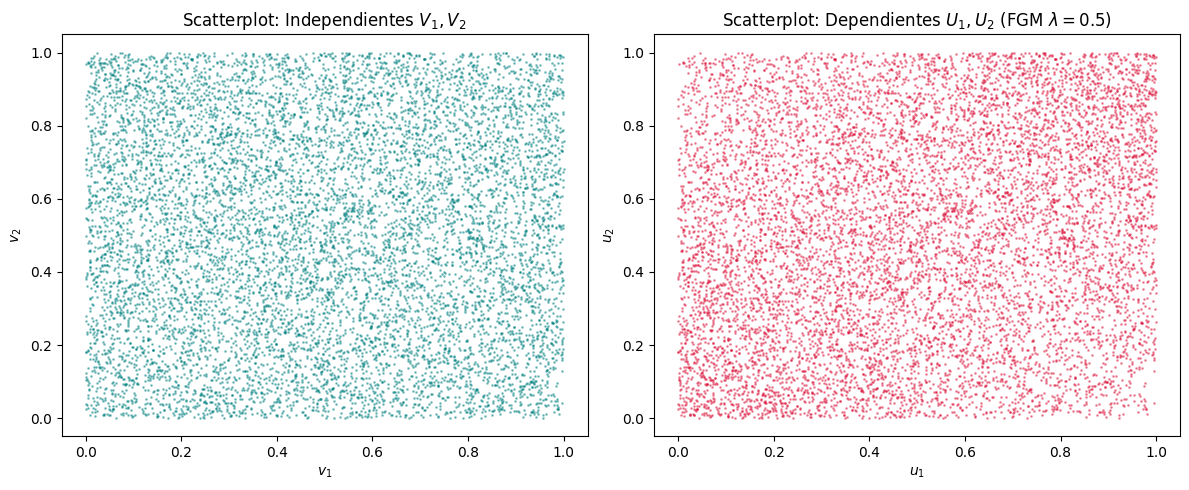

In [10]:
# Parámetros del ejercicio
N = 10000
lam = 0.5
np.random.seed(42)

# 1. Generar draws independientes de una Uniforme (0,1)
v1 = np.random.rand(N)
v2 = np.random.rand(N)

# 2. Obtener draws dependientes (u1, u2)
u2 = v2 # Según el enunciado u2 = v2
u1 = np.zeros(N)

for k in range(N):
    w = lam * (1 - 2 * u2[k])
    # Resolvemos la cuadrática: w*u1^2 - (1+w)*u1 + v1 = 0
    # Si w es 0 (independencia local), u1 = v1
    if abs(w) < 1e-10:
        u1[k] = v1[k]
    else:
        # Usamos la versión de la fórmula cuadrática que asegura estabilidad
        u1[k] = (2 * v1[k]) / ((1 + w) + np.sqrt((1 + w)**2 - 4 * w * v1[k]))

# 3. Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(v1, v2, s=1, color='teal', alpha=0.4)
ax1.set_title('Scatterplot: Independientes $V_1, V_2$')
ax1.set_xlabel('$v_1$')
ax1.set_ylabel('$v_2$')

ax2.scatter(u1, u2, s=1, color='crimson', alpha=0.4)
ax2.set_title(f'Scatterplot: Dependientes $U_1, U_2$ (FGM $\lambda=0.5$)')
ax2.set_xlabel('$u_1$')
ax2.set_ylabel('$u_2$')

plt.tight_layout()
plt.show()

### ii)

            Métrica     Valor
              Media  0.018267
Desviación Estándar  0.063510
           VaR (1%) -0.129713
           VaR (5%) -0.085998


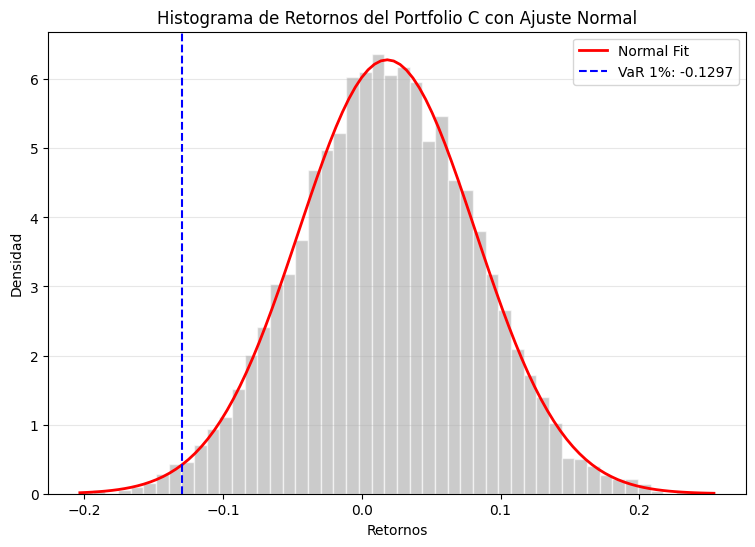

In [11]:
mu1, sigma1 = 0.01, 0.05  # Media y Volatilidad Stock 1
mu2, sigma2 = 0.02, 0.08  # Media y Volatilidad Stock 2

# 1. Transformación a retornos mediante la inversa de la CDF (Marginales)
R1 = norm.ppf(u1, loc=mu1, scale=sigma1)
R2 = norm.ppf(u2, loc=mu2, scale=sigma2)

# 2. Cálculo del Portfolio C (25% Stock 1, 75% Stock 2)
portfolio_C = 0.25 * R1 + 0.75 * R2

# 3. Cálculo de métricas
mean_C = np.mean(portfolio_C)
std_C = np.std(portfolio_C)
var_1 = np.percentile(portfolio_C, 1) # VaR al 1% (percentil 1)
var_5 = np.percentile(portfolio_C, 5) # VaR al 5% (percentil 5)

# Mostrar resultados limpios
metrics = pd.DataFrame({
    'Métrica': ['Media', 'Desviación Estándar', 'VaR (1%)', 'VaR (5%)'],
    'Valor': [mean_C, std_C, var_1, var_5]
})
print(metrics.to_string(index=False))

# 4. Histograma con ajuste Normal (Equivalente a histfit de Matlab)
plt.figure(figsize=(9, 6))
count, bins, ignored = plt.hist(portfolio_C, bins=50, density=True, alpha=0.6, color='darkgrey', edgecolor='white')

# Curva Normal teórica para el ajuste
x = np.linspace(min(portfolio_C), max(portfolio_C), 100)
plt.plot(x, norm.pdf(x, mean_C, std_C), color='red', lw=2, label='Normal Fit')

plt.axvline(var_1, color='blue', linestyle='--', label=f'VaR 1%: {var_1:.4f}')
plt.title('Histograma de Retornos del Portfolio C con Ajuste Normal')
plt.xlabel('Retornos')
plt.ylabel('Densidad')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

---

#### Exercise 7. 
Let $(U_1,U_2)$ be a bivariate uniform generated from the $G$ copula with $\rho=-0.7$ as correlation coefficient (standardized Gaussian copula), see section i) in Exercise 4. Repeat the same analysis as in Exercise 6 by obtaining $N=10{,}000$ draws of $(R_1,R_2)$ with marginal distributions of $R_i$ from the bivariate pdf (I).

The cdf of $U_1$ given $U_2=u_2$ in the $G$ copula (or conditional $G$ copula) is obtained from the cdf of the $G$ copula, $\Phi_2(\cdot)$, then

$$
C^{G}(u_1\mid u_2)
=
\frac{\partial}{\partial u_2}\,
\Phi_2\!\left(\Phi^{-1}(u_1),\Phi^{-1}(u_2)\right)
=
\Phi\!\left(
\frac{\Phi^{-1}(u_1)-\rho\,\Phi^{-1}(u_2)}{\sqrt{1-\rho^2}}
\right),
$$

where $\Phi(\cdot)$ and $\Phi^{-1}(\cdot)$ are, respectively, the $N(0,1)$ cdf and its inverse.

Obtain both the sample mean and standard deviation of the portfolio $D$ returns, containing $25\%$ of stock 1 and $75\%$ of stock 2 under the above procedure, and also the VaR values at $1\%$ and $5\%$.


> #### Exercise 7 Solution

La densidad conjunta (I) es

$$
f(r_1,r_2)=
\begin{cases}
\alpha+\beta r_1+\gamma r_2, & -1\le r_1\le 2,\; -2\le r_2\le 2.5,\\
0, & \text{en otro caso}.
\end{cases}
$$

Sus marginales son (integrando en el rectángulo):

$$
f_1(r_1)=\int_{-2}^{2.5}(\alpha+\beta r_1+\gamma r_2)\,dr_2
=4.5(\alpha+\beta r_1)+1.125\,\gamma,\qquad -1\le r_1\le 2,
$$

$$
f_2(r_2)=\int_{-1}^{2}(\alpha+\beta r_1+\gamma r_2)\,dr_1
=3(\alpha+\gamma r_2)+1.5\,\beta,\qquad -2\le r_2\le 2.5.
$$

Y sus cdf marginales:

$$
F_1(x)=\int_{-1}^{x} f_1(t)\,dt
=
\left(4.5\alpha+1.125\gamma\right)(x+1)+2.25\,\beta\,(x^2-1),\qquad -1\le x\le 2,
$$

$$
F_2(y)=\int_{-2}^{y} f_2(t)\,dt
=
\left(3\alpha+1.5\beta\right)(y+2)+1.5\,\gamma\,(y^2-4),\qquad -2\le y\le 2.5.
$$

La normalización de $f$ impone

$$
\int_{-1}^{2}\int_{-2}^{2.5}(\alpha+\beta r_1+\gamma r_2)\,dr_2\,dr_1
=13.5\,\alpha+6.75\,\beta+3.375\,\gamma=1.
$$

mean(D) = 0.821494
std(D)  = 0.701125
VaR 1%  = 0.90354   (VaR = -cuantil cola izqda)
VaR 5%  = 0.501716


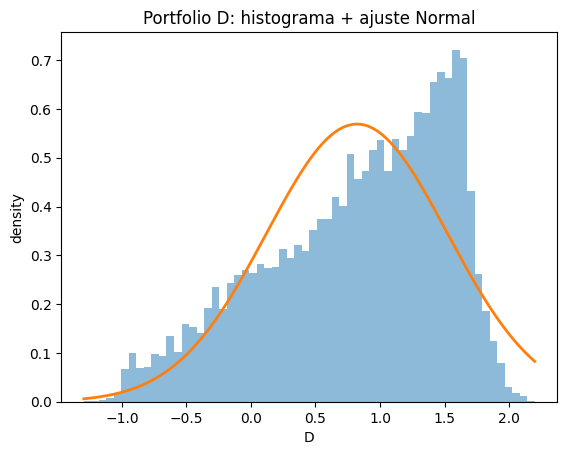

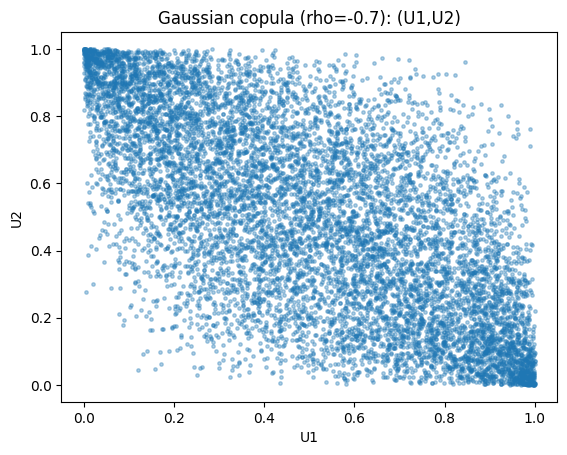

In [12]:
N = 10_000
rho = -0.7
seed = 123

alpha = 0.0642
beta  = 0.0049
gamma = 0.0296

# 1) Simular (U1,U2) con cópula Gaussiana
U1, U2 = gaussian_copula_uv(rho=rho, size=N, seed=seed)

# 2) Transformar con marginales de (I)
R1 = F1_ppf(U1, alpha, beta, gamma)
R2 = F2_ppf(U2, alpha, beta, gamma)

# 3) Portfolio D = 0.25 R1 + 0.75 R2
D = portfolio_returns(R1, R2, w1=0.25, w2=0.75)

mean_D = float(np.mean(D))
std_D  = float(np.std(D, ddof=1))
VaR_1  = var_left_tail(D, 0.01)
VaR_5  = var_left_tail(D, 0.05)

print(f"mean(D) = {mean_D:.6g}")
print(f"std(D)  = {std_D:.6g}")
print(f"VaR 1%  = {VaR_1:.6g}   (VaR = -cuantil cola izqda)")
print(f"VaR 5%  = {VaR_5:.6g}")

# Histograma + ajuste Normal
grid = np.linspace(np.min(D), np.max(D), 500)
mu_fit, sigma_fit, pdf_fit = normal_fit_pdf(D, grid)

plt.hist(D, bins=60, density=True, alpha=0.5)
plt.plot(grid, pdf_fit, linewidth=2)
plt.xlabel("D")
plt.ylabel("density")
plt.title("Portfolio D: histograma + ajuste Normal")
plt.show()

# scatter de (U1,U2)
plt.scatter(U1, U2, s=6, alpha=0.35)
plt.xlabel("U1")
plt.ylabel("U2")
plt.title("Gaussian copula (rho=-0.7): (U1,U2)")
plt.show()


---


#### Exercise 8.
 According to Exercise 7, the $q$ quantile curve under the $G$ copula, when the marginals are arbitrary distributions with cdf’s $F_i(\cdot)$, $i=1,2$, is given by

$$
C^{G}(u_1 \mid u_2)=q,
$$

then

$$
u_2
=
\Phi\!\left(
\rho\,\Phi^{-1}(u_1)
+
\sqrt{1-\rho^2}\,\Phi^{-1}(q)
\right),
$$

where $u_i = F_i(r_i)$.

Definitively,

$$
r_2
=
F_2^{-1}\!\left[
\Phi\!\left(
\rho\,\Phi^{-1}\!\big(F_1(r_1)\big)
+
\sqrt{1-\rho^2}\,\Phi^{-1}(q)
\right)
\right].
$$

Consider as marginals those obtained from the bivariate pdf (I). Make a plot of the $q$ quantile curves for

$$
q \in \{0.05,\,0.25,\,0.5,\,0.75,\,0.95\}.
$$


> #### Exercise 8 Solution

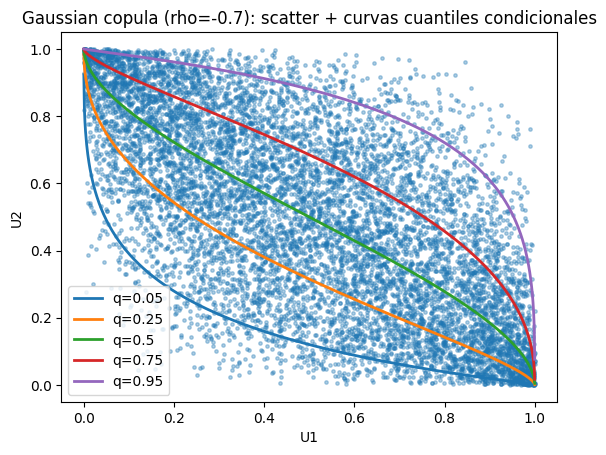

In [ ]:
rho = -0.7
qs = [0.05, 0.25, 0.50, 0.75, 0.95]

# malla en u1 evitando 0 y 1 para no tener inf en Phi^{-1}
u1_grid = np.linspace(1e-4, 1 - 1e-4, 800)
z1 = norm.ppf(u1_grid)

plt.scatter(U1, U2, s=6, alpha=0.35)
for q in qs:
    u2_curve = norm.cdf(rho * z1 + 
                        np.sqrt(1 - rho**2) *
                        norm.ppf(q))
    plt.plot(u1_grid, 
             u2_curve, 
             linewidth=2, 
             label=f"q={q}")

plt.xlabel("U1")
plt.ylabel("U2")
plt.title("Gaussian copula (rho=-0.7): " \
"scatter + curvas cuantiles condicionales")
plt.legend()
plt.show()


---

#### Exercise 9.

Repeat Exercise 8 where $u_i = \Phi(r_i) \ i=1,2$, then $r_2 = \rho r_1 + \sqrt{1 - \rho^2} \Phi^{-1}(q)$. Make again a plot of the $q$ quantile curves for $q = 0.05, 0.25, 0.5, 0.75, 0.95$.

> #### Exercise 9 Solution

Partiendo de la cópula Gaussiana bivariante $C^G(u_1, u_2)$, la curva de nivel para un cuantil $q$ se define como $P(U_2 \le u_2 | U_1 = u_1) = q$. La expresión condicional es:

$$
C_2(u_2|u_1) = \Phi\left( \frac{\Phi^{-1}(u_2) - \rho \Phi^{-1}(u_1)}{\sqrt{1-\rho^2}} \right) = q
$$

El enunciado establece que las marginales son Gaussianas: $u_i = \Phi(r_i)$. Por lo tanto, $\Phi^{-1}(u_i) = r_i$. Sustituyendo esto en la ecuación anterior:

$$
\Phi\left( \frac{r_2 - \rho r_1}{\sqrt{1-\rho^2}} \right) = q
$$

Aplicando la inversa $\Phi^{-1}$ a ambos lados para despejar el argumento:

$$
\frac{r_2 - \rho r_1}{\sqrt{1-\rho^2}} = \Phi^{-1}(q)
$$

Despejando $r_2$, obtenemos la relación lineal entre los retornos para un cuantil dado:

$$
r_2 = \rho r_1 + \sqrt{1-\rho^2} \cdot \Phi^{-1}(q)
$$

Esto demuestra que, bajo una cópula Gaussiana con marginales Gaussianas, las curvas de iso-cuantiles son líneas rectas.

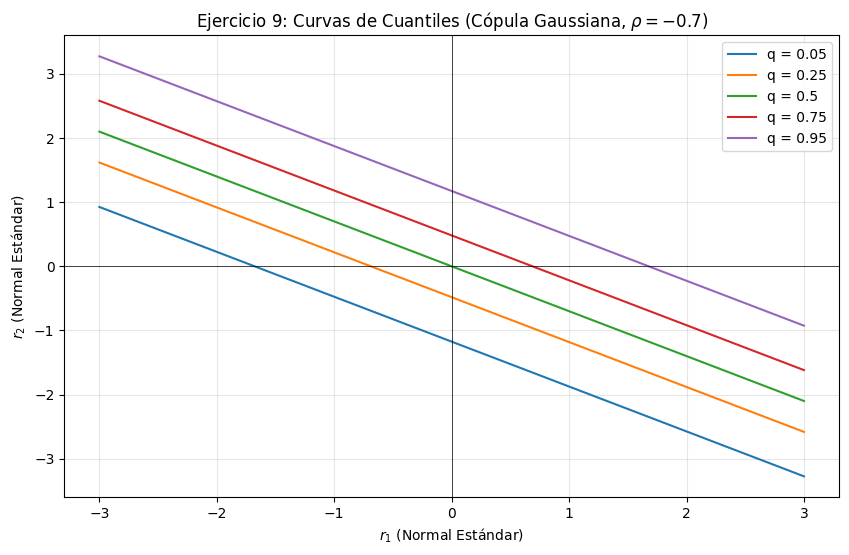

In [14]:
# Parámetros del ejercicio
rho = -0.7
q_values = [0.05, 0.25, 0.5, 0.75, 0.95]
r1_grid = np.linspace(-3, 3, 200)  # Rango para r1 (Normal Estándar)

plt.figure(figsize=(10, 6))

for q in q_values:
    # Fórmula derivada: r2 = rho * r1 + sqrt(1 - rho^2) * Phi^-1(q)
    z_q = norm.ppf(q)
    r2_line = rho * r1_grid + np.sqrt(1 - rho**2) * z_q
    
    plt.plot(r1_grid, r2_line, label=f'q = {q}')

plt.title(f'Ejercicio 9: Curvas de Cuantiles (Cópula Gaussiana, $\\rho={rho}$)')
plt.xlabel('$r_1$ (Normal Estándar)')
plt.ylabel('$r_2$ (Normal Estándar)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

#### Exercise 10. 
The cdf of the conditional Clayton copula is
$$
C^{Cla}(u_1 \mid u_2)
=
\frac{\partial}{\partial u_2}
\left(u_1^{-\theta}+u_2^{-\theta}-1\right)^{-1/\theta}
=
u_1^{-(1+\theta)}
\left(u_1^{-\theta}+u_2^{-\theta}-1\right)^{-(1+\theta)/\theta},
$$

such that $\theta>0$. Given the equation

$$
C^{Cla}(u_1 \mid u_2)=q,
$$

the $q$ quantile for the Clayton copula is obtained as

$$
u_2
=
\left(
1+u_1^{-\theta}\big(q^{-\theta/(1+\theta)}-1\big)
\right)^{-1/\theta},
$$

where $u_i=F_i(r_i)$.

If we set the marginals to be those obtained from the bivariate pdf (I), then

$$
r_2
=
F_2^{-1}\!\left[
\left(
1+F_1(r_1)^{-\theta}\big(q^{-\theta/(1+\theta)}-1\big)
\right)^{-1/\theta}
\right].
$$

Draw the $q$ quantile curves for

$$
q \in \{0.05,\,0.25,\,0.5,\,0.75,\,0.95\}.
$$


> #### Exercise 10 Solution

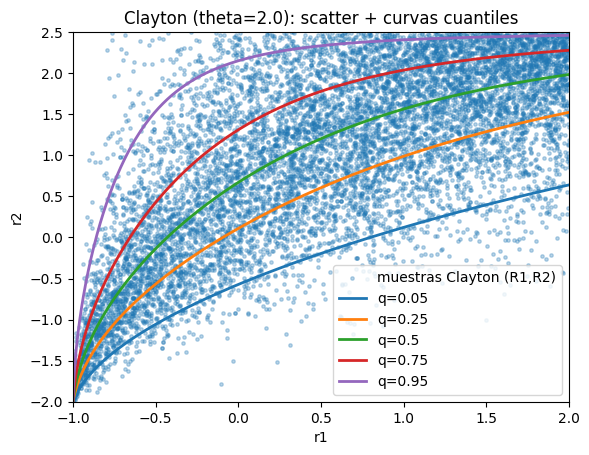

In [15]:
N = 10_000
theta = 2.0
qs = [0.05, 0.25, 0.50, 0.75, 0.95]
seed = 123

# 1) scatter con dependencia Clayton(theta)
R1, R2, U1, U2 = clayton_returns_from_pdfI(
    theta=theta, 
    size=N, 
    alpha=alpha, 
    beta=beta, 
    gamma=gamma, 
    seed=seed
)

plt.scatter(R1, R2, s=6, alpha=0.30, label="muestras Clayton (R1,R2)")

# 2) curvas cuantiles Clayton en (r1,r2)
r1_grid = np.linspace(-1.0 + 1e-6, 2.0 - 1e-6, 800)
for q in qs:
    r2_curve = clayton_quantile_curve_r2(
        r1_grid, 
        q=q, 
        theta=theta, 
        alpha=alpha, 
        beta=beta, 
        gamma=gamma
    )
    plt.plot(r1_grid, r2_curve, linewidth=2, label=f"q={q}")

plt.xlabel("r1")
plt.ylabel("r2")
plt.title(f"Clayton (theta={theta}): scatter + curvas cuantiles")
plt.legend()
plt.xlim(-1, 2)
plt.ylim(-2, 2.5)
plt.show()

---

#### Exercise 11.

The four steps to simulate under a bivariate $G$ copula with an alternative procedure are: **(a)** Find the Cholesky decomposition $L$ of correlation matrix $\Psi = L'L$; **(b)** Generate draws $(v_1, v_2)$ of indep. $V_i \sim U(0,1)$ to obtain draws $(z_1, z_2) = (\Phi^{-1}(v_1), \Phi^{-1}(v_2))$ of indep. $Z_i \sim N(0,1)$; **(c)** Generate draws $x = Lz$ with $z = (z_1, z_2)'$ of the bivariate $X = LZ \sim N(0, \Psi)$; **(d)** Set $u_i = \Phi(x_i)$ which are draws of the bivariate uniform $(U_1, U_2)$ from the $G$ copula. The expression of $L$ is given by $L = \begin{bmatrix} 1 & 0 \\ \rho & \sqrt{1 - \rho^2} \end{bmatrix}$. Repeat Exercise 7 by using the above method.

> #### Exercise 11 Solution

1.  **Generación de Dependencia:** Se utiliza la descomposición de Cholesky ($L$) de la matriz de correlación $\Psi$ tal que $\Psi = LL^T$.
    * Sea $Z \sim N(0, I)$.
    * Generamos variables correlacionadas $X = LZ$.
    * Obtenemos uniformes dependientes $U_i = \Phi(X_i)$.

2.  **Transformación a Marginales (Inverse Transform):**
    Usando el resultado del Ejercicio 1 (Distribución Triangular), la función inversa $F^{-1}(u)$ es:
    
    $$
    F^{-1}(u) = 
    \begin{cases} 
    1 + \sqrt{8u} & \text{si } 0 \le u \le 0.5 \\
    5 - \sqrt{8(1-u)} & \text{si } 0.5 < u \le 1
    \end{cases}
    $$

In [16]:
# --- 1. Simulación de Cópula Gaussiana ---
np.random.seed(42) # Semilla para reproducibilidad
N = 10000
rho = -0.7

# Matriz Cholesky para caso bivariante
# L = [[1, 0], [rho, sqrt(1-rho^2)]]
Psi = np.array([[1, rho], [rho, 1]])
L = np.linalg.cholesky(Psi)

# Generar normales independientes y correlacionarlas
Z = np.random.normal(0, 1, size=(2, N))
X = np.dot(L, Z)

# Obtener uniformes correlacionados
U_sim = norm.cdf(X) # Fila 0 es U1, Fila 1 es U2

# --- 2. Obtener Retornos Reales ---
R1_sim = inverse_triangular(U_sim[0, :])
R2_sim = inverse_triangular(U_sim[1, :])

# --- 3. Calcular Portafolio D (25% Stock 1, 75% Stock 2) ---
w1, w2 = 0.25, 0.75
port_D = w1 * R1_sim + w2 * R2_sim

# Resultados
print(f"Media: {np.mean(port_D):.4f}")
print(f"Desviación Estándar: {np.std(port_D):.4f}")
print(f"VaR 1%: {np.percentile(port_D, 1):.4f}")
print(f"VaR 5%: {np.percentile(port_D, 5):.4f}")

Media: 3.0063
Desviación Estándar: 0.4934
VaR 1%: 1.9584
VaR 5%: 2.1820


---

### Exercise 12. 
Using the Cholesky decomposition in Exercise 11 is easy to simulate draws from the bivariate Student $t$ copula (hereafter, $T$ copula). The steps (a) and (b) are the same; 

(c) Simulate a draw $s$ from the random variate $\chi^2_\nu$ independent of $Z$;

(d) Generate draws 
$$
y = \sqrt{\frac{\nu}{s}}\, x
$$
where $x = Lz$ with $z = (z_1, z_2)'$ of the bivariate 
$$
X = LZ \sim N(0, \Psi);
$$

(e) Set 
$$
u_i = T_\nu(y_i)
$$
where $T_\nu$ denotes the cdf of the univariate Student $t$ distribution.

Definitively, $u_i = T_\nu(y_i)$ are draws of the bivariate uniform $(U_1, U_2)$ from the $T$ copula. Repeat Exercise 7 by using the $T$ copula instead of the $G$ copula with marginals those from the bivariate pdf (I). Consider $\rho = -0.7$ and $\nu = 5$.

Obtain both the sample mean and standard deviation of the portfolio $E$ returns, containing $25\%$ of stock 1 and $75\%$ of stock 2 under the above procedure, and also the VaR values at $1\%$ and $5\%$.


> #### Exercise 12 Solution

In [17]:
N = 10_000
rho = -0.7
nu  = 5
seed = 123

alpha = 0.0642
beta  = 0.0049
gamma = 0.0296

# 1) Simular (U1,U2) con t-cópula
U1, U2 = t_copula_uv(rho=rho, nu=nu, size=N, seed=seed)

# 2) Transformar con marginales de (I)
R1 = F1_ppf(U1, alpha, beta, gamma)
R2 = F2_ppf(U2, alpha, beta, gamma)

# 3) Portfolio E = 0.25 R1 + 0.75 R2
E = portfolio_returns(R1, R2, w1=0.25, w2=0.75)

mean_E = float(np.mean(E))
std_E  = float(np.std(E, ddof=1))
VaR_1  = var_left_tail(E, 0.01)
VaR_5  = var_left_tail(E, 0.05)

print(f"mean(E) = {mean_E:.6g}")
print(f"std(E)  = {std_E:.6g}")
print(f"VaR 1%  = {VaR_1:.6g}   (VaR = -cuantil cola izqda)")
print(f"VaR 5%  = {VaR_5:.6g}")


mean(E) = 0.824927
std(E)  = 0.707438
VaR 1%  = 0.851855   (VaR = -cuantil cola izqda)
VaR 5%  = 0.508001


---

### Exercise 13

Compute the sample covariance and correlation matrices of the portfolio return series $A$, $B$, $C$, $D$ and $E$ already obtained in Exercises 3, 6, 7 and 12. Obtain also the skewness and kurtosis of each of them. Build an equally weighted ($EW$) portfolio series containing the five portfolio return series. Compute the mean, variance, skewness and kurtosis of the $EW$ return series. Obtain the QQ plot of the standardized $EW$ return series.


> #### Exercise 13 Solution

<span style="color:red">
NECESARIO EL EJERCICIO 3 PARA PODER HACER EL 13 - PORTFOLIOS A,B
</span>


---

#### Exercise 14.

Consider Exercise 11 for the trivariate $G$ copula with correlation matrix $\Psi = \begin{bmatrix} 1 & \rho_{12} & \rho_{13} \\ \rho_{12} & 1 & \rho_{23} \\ \rho_{13} & \rho_{23} & 1 \end{bmatrix}$. Show that $X = LZ \sim N(0, \Psi)$ where $L$ is the Cholesky decomposition of $\Psi = L L'$ given by

$$L = \begin{bmatrix} 1 & 0 & 0 \\ \rho_{12} & \sqrt{1 - \rho_{12}^2} & 0 \\ \rho_{13} & \frac{\rho_{23} - \rho_{12}\rho_{13}}{\sqrt{1 - \rho_{12}^2}} & \sqrt{1 - \rho_{13}^2 - \frac{(\rho_{23} - \rho_{12}\rho_{13})^2}{1 - \rho_{12}^2}} \end{bmatrix}.$$

> #### Exercise 14 Solution

Dada una matriz de correlación simétrica $\Psi$:

$$
\Psi = \begin{pmatrix} 
1 & \rho_{12} & \rho_{13} \\ 
\rho_{12} & 1 & \rho_{23} \\ 
\rho_{13} & \rho_{23} & 1 
\end{pmatrix}
$$

Buscamos una matriz triangular inferior $L$ tal que $LL^T = \Psi$:

$$
\begin{pmatrix} 
l_{11} & 0 & 0 \\ 
l_{21} & l_{22} & 0 \\ 
l_{31} & l_{32} & l_{33} 
\end{pmatrix}
\begin{pmatrix} 
l_{11} & l_{21} & l_{31} \\ 
0 & l_{22} & l_{32} \\ 
0 & 0 & l_{33} 
\end{pmatrix}
= \Psi
$$

**Resolución:**

**Columna 1:**
1.  $l_{11}^2 = 1 \implies \mathbf{l_{11} = 1}$
2.  $l_{21}l_{11} = \rho_{12} \implies \mathbf{l_{21} = \rho_{12}}$
3.  $l_{31}l_{11} = \rho_{13} \implies \mathbf{l_{31} = \rho_{13}}$

**Columna 2:**
4.  $l_{21}^2 + l_{22}^2 = 1 \implies \rho_{12}^2 + l_{22}^2 = 1 \implies \mathbf{l_{22} = \sqrt{1 - \rho_{12}^2}}$
5.  $l_{31}l_{21} + l_{32}l_{22} = \rho_{23}$. Sustituyendo:
    $$\rho_{13}\rho_{12} + l_{32}\sqrt{1 - \rho_{12}^2} = \rho_{23}$$
    $$\mathbf{l_{32} = \frac{\rho_{23} - \rho_{12}\rho_{13}}{\sqrt{1 - \rho_{12}^2}}}$$

**Columna 3:**
6.  $l_{31}^2 + l_{32}^2 + l_{33}^2 = 1$. Sustituyendo:
    $$\rho_{13}^2 + \left( \frac{\rho_{23} - \rho_{12}\rho_{13}}{\sqrt{1 - \rho_{12}^2}} \right)^2 + l_{33}^2 = 1$$
    $$\mathbf{l_{33} = \sqrt{1 - \rho_{13}^2 - \left( \frac{\rho_{23} - \rho_{12}\rho_{13}}{\sqrt{1 - \rho_{12}^2}} \right)^2}}$$

---

#### Exercise 15.
**Exercise 15.** Consider the three daily return series (*Apple, Amazon and Pfizer*) in file "stocks.xlsx", each with length $T = 3,892$. Answer the following questions:

**i)** Plot the empirical distribution function (EDF) for each standardized return series (you can use `cdfplot` in Matlab).  
**Hint 1:** See *EDF* in https://en.wikipedia.org/wiki/Empirical_distribution_function

**ii)** Assume a trivariate $G$ copula pdf, see section i) in Exercise 4 for the bivariate case. Estimate the correlation matrix $\Psi$ under maximum likelihood (ML) with input series: $\hat{\eta}_t = \left( \Phi^{-1}(\hat{u}_{1t}), \Phi^{-1}(\hat{u}_{2t}), \Phi^{-1}(\hat{u}_{3t}) \right)'$, $t = 1, \dots, T$ such that $\hat{u}_{it}$ is $EDF_i$. **Hint 2:** The ML estimation of $\Psi$ is given by $\hat{\Psi}_{ML} = T^{-1} \sum_{t=1}^T \hat{\eta}_t \hat{\eta}_t'$ with $\hat{\eta}_{it} = \Phi^{-1}(\hat{u}_{it})$. The correlation matrix estimation can be *renormalized* so that all diagonal elements equal one.

**iii)** Generate by Monte Carlo an equally weighted (EW) portfolio series of length $N = 10,000$ containing the three stocks under the $G$ copula with $\hat{\Psi}_{ML}$ obtained in section ii), and marginal distribution for the stock return $i$ given by $R_i = \mu_i + \sigma_i Z_i$; $Z_i \sim ST_{\nu_i}$; $E(Z_i) = 0$; $E(Z_i^2) = 1$, with $ST_{\nu_i} = \sqrt{\frac{\nu_i - 2}{\nu_i}} T_{\nu_i}$ as the *standardized Student-T distribution* with degrees of freedom $\nu_i > 2$. The estimation of $\nu_i$ is based on either ML or MM (method-of-moments), the estimation of $\mu_i$ and $\sigma_i$ are the sample mean and standard deviation of the stock return $i$. Compute the sample mean, standard deviation, skewness, kurtosis and VaR (1% and 5%) for the EW portfolio return series.

> #### Exercise 15 Solution

**Procedimiento:**
1.  **Plot EDF:** Visualización de la función de distribución empírica de los retornos estandarizados.
2.  **Correlación (MLE Cópula Gaussiana):** Estimación de la matriz $\Psi$ transformando los datos al espacio normal mediante $\Phi^{-1}(\hat{u})$.
3.  **Simulación:** Simulación de Monte Carlo de un portafolio equiponderado (EW) asumiendo marginales t-Student (con $v=5$ grados de libertad) y estructura de dependencia Gaussiana estimada.

In [18]:
# --- Carga de Datos ---
try:
    df = pd.read_excel('stocks.xlsx')
    # Ajustar nombres de columnas según el excel real, asumo Apple, Amazon, Pfizer
    cols = ['APPLE', 'AMAZON', 'PFIZER'] 
    returns = df[cols].dropna()
    print(f"Datos cargados exitosamente: {len(returns)} observaciones.")
except FileNotFoundError:
    print("Error: No se encuentra 'stocks.xlsx'. Asegúrate de subir el archivo.")
    # Generar datos dummy si falla la carga para demostrar el código
    np.random.seed(42)
    returns = pd.DataFrame(np.random.normal(0,0.01, (1000,3)), columns=['APPLE','AMAZON','PFIZER'])
except Exception as e:
    print(f"Ocurrió un error al leer el archivo: {e}")
    # Fallback dummy data
    returns = pd.DataFrame(np.random.normal(0,0.01, (1000,3)), columns=['APPLE','AMAZON','PFIZER'])

# Estandarización
std_returns = (returns - returns.mean()) / returns.std()
T = len(returns)

Error: No se encuentra 'stocks.xlsx'. Asegúrate de subir el archivo.


### i)

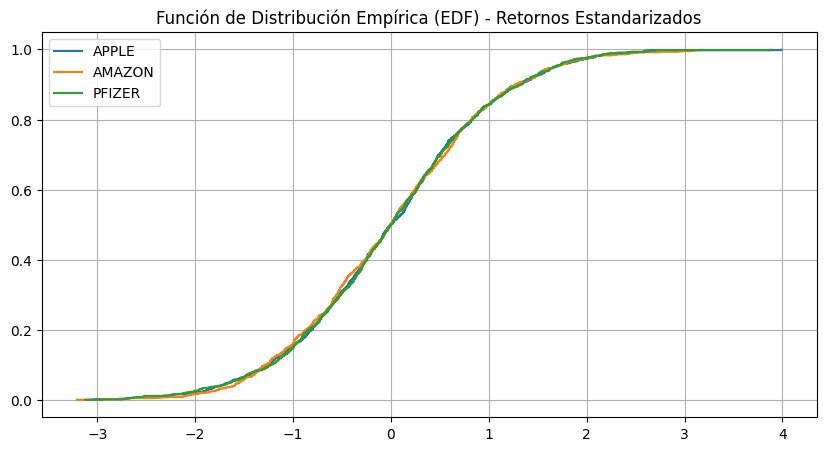

In [19]:
plt.figure(figsize=(10, 5))
for col in std_returns.columns:
    sorted_data = np.sort(std_returns[col])
    p = np.arange(1, T + 1) / (T + 1)
    plt.step(sorted_data, p, label=col, where='post')

plt.title('Función de Distribución Empírica (EDF) - Retornos Estandarizados')
plt.grid(True)
plt.legend()
plt.show()

### ii)

In [20]:
# Transformación a normales usando norm.ppf directamente
u_hat = returns.rank(method='first') / (T + 1)
eta_hat = norm.ppf(u_hat) 
Psi_ML = pd.DataFrame(eta_hat, columns=returns.columns).corr()

print("\nMatriz de Correlación Estimada (MLE Cópula Gaussiana):")
print(Psi_ML)


Matriz de Correlación Estimada (MLE Cópula Gaussiana):
           APPLE    AMAZON    PFIZER
APPLE   1.000000 -0.044667 -0.018913
AMAZON -0.044667  1.000000  0.033082
PFIZER -0.018913  0.033082  1.000000


### iii)

In [21]:
N_sim = 10000
v = 5 # Grados de libertad asumidos para t-Student

# A. Simular dependencia Gaussiana
# Usamos Cholesky sobre la matriz de correlación estimada
L_ml = np.linalg.cholesky(Psi_ML.values)
Z = np.random.normal(0, 1, (3, N_sim))
# Generamos uniformes correlacionados
U_sim = norm.cdf(np.dot(L_ml, Z))

# B. Transformar a marginales t-Student estandarizadas
# Nota: t.ppf devuelve var = v/(v-2). Debemos re-escalar para que var=1
scale_factor = np.sqrt((v - 2) / v)
sim_ret = np.zeros((3, N_sim))

for i, col in enumerate(returns.columns):
    # Inversa t-student * factor de escala para tener var=1
    z_student = t.ppf(U_sim[i, :], df=v) * scale_factor
    # Aplicar mu y sigma históricos
    sim_ret[i, :] = returns[col].mean() + returns[col].std() * z_student

# C. Calcular Portafolio EW (Equally Weighted)
w_ew = np.array([1/3, 1/3, 1/3])
port_ew = np.dot(w_ew, sim_ret)

# Resultados
print(f"Media: {np.mean(port_ew):.5f}")
print(f"Desviación: {np.std(port_ew):.5f}")
print(f"Skewness: {skew(port_ew):.4f}")
print(f"Kurtosis: {kurtosis(port_ew):.4f} (exceso)")
print(f"VaR 1%: {np.percentile(port_ew, 1):.5f}")
print(f"VaR 5%: {np.percentile(port_ew, 5):.5f}")

Media: 0.00027
Desviación: 0.00579
Skewness: -0.0275
Kurtosis: 2.3615 (exceso)
VaR 1%: -0.01414
VaR 5%: -0.00898


---

### Exercise 16
The cdf of the conditional copula for a bivariate Normal mixture (NM) copula is easy to derive from the bivariate $G$ copula in Exercise 7:

$$
C^{NM}(u_1 \mid u_2)
=
\pi \, \Phi\!\left(
\frac{\Phi^{-1}(u_1) - \rho_1 \Phi^{-1}(u_2)}
{\sqrt{1 - \rho_1^2}}
\right)
+
(1-\pi)\, \Phi\!\left(
\frac{\Phi^{-1}(u_1) - \rho_2 \Phi^{-1}(u_2)}
{\sqrt{1 - \rho_2^2}}
\right),
$$

where $0 < \pi < 1$. However, this time the $q$ quantile curves cannot be expressed as an explicit function and numerical methods need to be used to back out a value of $u_2$ from
$$
C^{NM}(u_1 \mid u_2) = q
$$
for each $u_1$ and $q$. If we set the marginals $F_i(\cdot)$, $i=1,2$, those from the bivariate pdf (I), i.e.,
$$
r_i = F_i^{-1}(u_i),
$$
draw the $q$ quantile curves for
$$
q = 0.05,\, 0.25,\, 0.5,\, 0.75,\, 0.95
$$
when $\pi = 0.3$, $\rho_1 = -0.7$, $\rho_2 = 0.4$.


> #### Exercise 16 Solution

En este ejercicio se pretende obtener las curvas cuantiles $q$ de la cópula condicional Normal Mixture (NM), definida como una combinación convexa de dos cópulas gaussianas condicionales:

$$
C^{NM}(u_1 \mid u_2)
=
\pi C^G_{\rho_1}(u_1 \mid u_2)
+
(1-\pi) C^G_{\rho_2}(u_1 \mid u_2),
$$

donde

$$
C^G_{\rho}(u_1 \mid u_2)
=
\Phi\!\left(
\frac{\Phi^{-1}(u_1)-\rho\,\Phi^{-1}(u_2)}
{\sqrt{1-\rho^2}}
\right).
$$

El problema consiste en fijar un nivel $q \in \{0.05, 0.25, 0.5, 0.75, 0.95\}$ y resolver, para cada valor de $u_1$, la ecuación implícita

$$
C^{NM}(u_1 \mid u_2) = q,
$$

obteniendo así $u_2$ como función de $u_1$.

A diferencia del caso puramente gaussiano, esta ecuación no puede invertirse de forma analítica, ya que se trata de una mezcla de dos funciones no lineales. Por tanto, es necesario recurrir a métodos numéricos de búsqueda de raíces. Para cada par $(u_1, q)$ se define la función

$$
f(u_2) = C^{NM}(u_1 \mid u_2) - q,
$$

y se resuelve la ecuación $f(u_2)=0$ en el intervalo $(0,1)$ mediante un algoritmo de tipo Brent o bisección. La monotonía de la función en $u_2$ garantiza la existencia y unicidad de la solución.

Una vez obtenida la curva $u_2(u_1)$ en el espacio uniforme, se transforma al espacio de rendimientos utilizando las marginales procedentes de la pdf (I):

$$
r_1 = F_1^{-1}(u_1), 
\qquad
r_2 = F_2^{-1}(u_2).
$$

De esta forma se obtienen las curvas cuantiles en el plano $(r_1,r_2)$.

En resumen, el procedimiento seguido es: fijar los parámetros $\pi=0.3$, $\rho_1=-0.7$, $\rho_2=0.4$; construir una malla para $u_1$; resolver numéricamente la ecuación anterior para cada $q$ y cada punto de la malla; y finalmente transformar los resultados mediante las inversas marginales. El elemento central del ejercicio es la inversión numérica de una relación implícita derivada de una mezcla de cópulas gaussianas.

Nosotros realizamos además una simulación de los puntos de la cópula NM, para tener una mayor intuición acerca de dónde se sitúan los cuantiles, en función de los puntos de la muestra.

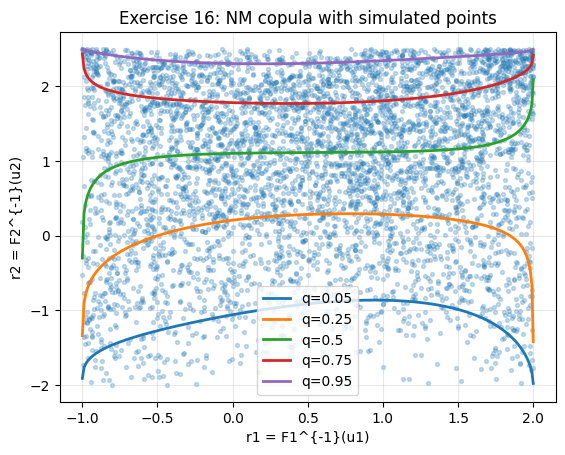

In [22]:
pi = 0.3
rho1 = -0.7
rho2 = 0.4
q_list = [0.05, 0.25, 0.5, 0.75, 0.95]

# Marginal params from pdf (I) (ajusta si tus alpha/beta/gamma cambian)
alpha = 0.0642
beta  = 0.0049
gamma = 0.0296

# Grid for u1 (avoid 0 and 1 for numerical stability)
M = 300
u1_grid = np.linspace(1e-4, 1 - 1e-4, M)

# Simular puntos de la cópula
N_sim = 5000
U1_sim, U2_sim = simulate_nm_copula(
    N_sim, pi=pi, rho1=rho1, rho2=rho2, seed=123
)

# Transformar a espacio de retornos
R1_sim = F1_ppf(U1_sim, alpha, beta, gamma)
R2_sim = F2_ppf(U2_sim, alpha, beta, gamma)

plt.figure()

# Scatter de la cópula (fondo)
plt.scatter(R1_sim, R2_sim, s=8, alpha=0.25)

# Curvas cuantiles (líneas continuas)
for q in q_list:
    u2_curve = np.array([
        solve_u2_for_quantile(u1, q, pi=pi, rho1=rho1, rho2=rho2)
        for u1 in u1_grid
    ])

    r1_curve = F1_ppf(u1_grid, alpha, beta, gamma)
    r2_curve = F2_ppf(u2_curve, alpha, beta, gamma)

    plt.plot(r1_curve, r2_curve, linewidth=2, label=f"q={q:g}")

plt.xlabel("r1 = F1^{-1}(u1)")
plt.ylabel("r2 = F2^{-1}(u2)")
plt.title("Exercise 16: NM copula with simulated points")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---

#### Exercise 17.

**Exercise 17.** Repeat the same analysis as in section iv) in Exercise 3 but considering as marginal distributions for the returns the *Truncated Normal* (TN) distribution, $R_i \sim TN(a_i, b_i, \tilde{\mu}_i, \tilde{\sigma}_i)$ with pdf $f_i(r_i) = \frac{1}{\tilde{\sigma}_i} \frac{\phi((r_i - \tilde{\mu}_i)/\tilde{\sigma}_i)}{\Phi(\tilde{b}_i) - \Phi(\tilde{a}_i)}$ such that $a_i < r_i < b_i, \ \tilde{\sigma}_i > 0, \ \tilde{a}_i = (a_i - \tilde{\mu}_i)/\tilde{\sigma}_i$ and $\tilde{b}_i = (b_i - \tilde{\mu}_i)/\tilde{\sigma}_i$. Both mean and standard deviation of $R_i$, denoted as $\mu_i$ and $\sigma_i$, are: $\mu_i = \tilde{\mu}_i - \tilde{\sigma}_i B_i$; $\sigma_i = \tilde{\sigma}_i \sqrt{1 - A_i - B_i^2}$; $A_i = \frac{\tilde{b}_i \phi(\tilde{b}_i) - \tilde{a}_i \phi(\tilde{a}_i)}{\Phi(\tilde{b}_i) - \Phi(\tilde{a}_i)}$; $B_i = \frac{\phi(\tilde{b}_i) - \phi(\tilde{a}_i)}{\Phi(\tilde{b}_i) - \Phi(\tilde{a}_i)}$. By using the "inverse transform method" for simulated random variables, we have:

$$R_i = \tilde{\mu}_i + \tilde{\sigma}_i \cdot \Phi^{-1} \left( \Phi(\tilde{a}_i) + U_i \cdot [\Phi(\tilde{b}_i) - \Phi(\tilde{a}_i)] \right); \quad i=1,2$$

where $\phi(\cdot)$ and $\Phi(\cdot)$ denote, respectively, pdf and cdf of the $N(0,1)$ distribution, and $(U_1, U_2)$ is a bivariate uniform random vector under the "conditional sampling" in section iv) in Exercise 3. The values of $(a_i, b_i)$ are the same as those in Exercise 3, while $\mu_i$ and $\sigma_i$ are set to be equal to those from the implied marginal distribution of $R_i$ in the pdf (I). Thus, $(\mu_1, \sigma_1) = (0.55, 0.86)$ and $(\mu_2, \sigma_2) = (0.93, 1.11)$. Compute both the sample mean and standard deviation of portfolio **F** returns, containing 25% of stock 1 and 75% of stock 2 under the above procedure, and also the VaR values at 1% and 5%. Compare these VaR values of portfolio **F** with those from portfolios **A** and **B**.

**Hint:** See https://en.wikipedia.org/wiki/Truncated_normal_distribution.

> #### Exercise 17 Solution

**Fórmula de Generación:**
Utilizando el método de la transformada inversa para la Normal Truncada $TN(a, b, \tilde{\mu}, \tilde{\sigma})$, la variable aleatoria $R_i$ se obtiene a partir de un uniforme $U_i$ mediante:

$$
R_i = \tilde{\mu}_i + \tilde{\sigma}_i \cdot \Phi^{-1}\left[ \Phi(\tilde{a}_i) + U_i \cdot (\Phi(\tilde{b}_i) - \Phi(\tilde{a}_i)) \right]
$$

Donde $\tilde{a}_i = \frac{a_i - \tilde{\mu}_i}{\tilde{\sigma}_i}$ y $\tilde{b}_i = \frac{b_i - \tilde{\mu}_i}{\tilde{\sigma}_i}$ son los límites estandarizados.

In [23]:
# Parámetros del ejercicio
params = [
    {'a': -1.0, 'b': 2.0, 'mu': 0.55, 'sigma': 0.86}, # Stock 1
    {'a': -2.0, 'b': 2.5, 'mu': 0.93, 'sigma': 1.11}  # Stock 2
]

# Usamos los uniformes U_sim calculados en el Ejercicio 11 
# para mantener la dependencia de Cholesky
R1_TN = simulate_truncated(U_sim[0, :], params[0])
R2_TN = simulate_truncated(U_sim[1, :], params[1])

# Portafolio F (25% / 75%)
port_F = 0.25 * R1_TN + 0.75 * R2_TN

print(f"Media: {np.mean(port_F):.4f}")
print(f"Desviación: {np.std(port_F):.4f}")
print(f"VaR 1%: {np.percentile(port_F, 1):.4f}")
print(f"VaR 5%: {np.percentile(port_F, 5):.4f}")

Media: 0.7148
Desviación: 0.7212
VaR 1%: -1.0532
VaR 5%: -0.5279


---
---

---
---

Prueba: Kernel Gaussiano para densidad continua *teórica*

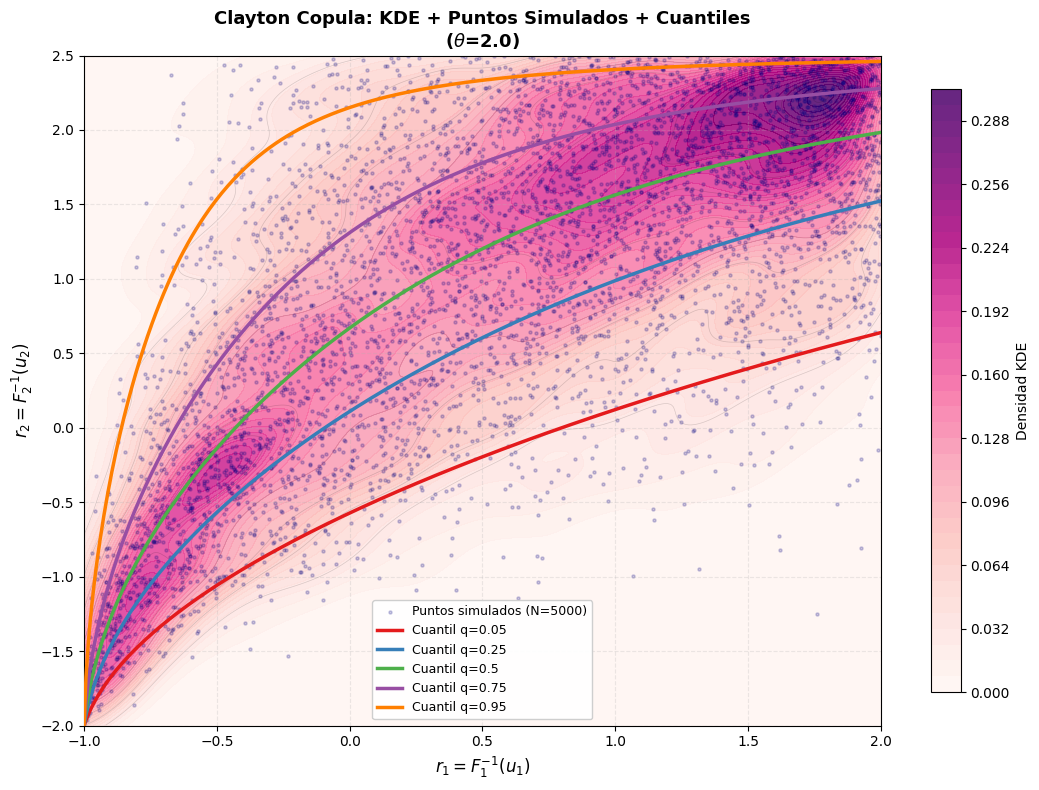

In [24]:
# Combinación Clayton: KDE (fondo) + puntos simulados + curvas de cuantiles
from scipy.stats import gaussian_kde

# Parámetros Clayton
theta_clayton = 2.0
qs_clayton = [0.05, 0.25, 0.50, 0.75, 0.95]

# Simular puntos de la cópula Clayton
N_clayton = 5000
R1_clayton, R2_clayton, U1_clayton, U2_clayton = clayton_returns_from_pdfI(
    theta=theta_clayton, 
    size=N_clayton, 
    alpha=alpha, 
    beta=beta, 
    gamma=gamma, 
    seed=456
)

# Calcular KDE bidimensional
data_clayton = np.vstack([R1_clayton, R2_clayton])
kde_clayton = gaussian_kde(data_clayton, bw_method=0.15)  # Menor bw = más detalle

# Grid para el contour (más fino para mejor resolución)
xmin_c, xmax_c = R1_clayton.min(), R1_clayton.max()
ymin_c, ymax_c = R2_clayton.min(), R2_clayton.max()
X_c, Y_c = np.mgrid[xmin_c:xmax_c:300j, ymin_c:ymax_c:300j]
positions_c = np.vstack([X_c.ravel(), Y_c.ravel()])
Z_c = np.reshape(kde_clayton(positions_c).T, X_c.shape)

# Crear figura
plt.figure(figsize=(11, 8))

# 1. Fondo: densidad kernel con contourf (más niveles y alpha más alto)
contour_c = plt.contourf(X_c, Y_c, Z_c, levels=40, cmap='RdPu', alpha=0.85)
plt.colorbar(contour_c, label='Densidad KDE', shrink=0.9)

# Añadir contornos de línea para resaltar la densidad
plt.contour(X_c, Y_c, Z_c, levels=10, colors='black', alpha=0.15, linewidths=0.5)

# 2. Puntos simulados (más transparentes para no ocultar la densidad)
plt.scatter(R1_clayton, R2_clayton, s=5, alpha=0.20, color='navy', 
            label=f'Puntos simulados (N={N_clayton})')

# 3. Curvas de cuantiles Clayton
colors_clayton = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
r1_grid_clayton = np.linspace(-1.0 + 1e-6, 2.0 - 1e-6, 400)

for i, q in enumerate(qs_clayton):
    r2_curve_clayton = clayton_quantile_curve_r2(
        r1_grid_clayton, 
        q=q, 
        theta=theta_clayton, 
        alpha=alpha, 
        beta=beta, 
        gamma=gamma
    )
    plt.plot(r1_grid_clayton, r2_curve_clayton, linewidth=2.5, 
             color=colors_clayton[i], label=f'Cuantil q={q:g}', zorder=10)

plt.xlabel('$r_1 = F_1^{-1}(u_1)$', fontsize=12)
plt.ylabel('$r_2 = F_2^{-1}(u_2)$', fontsize=12)
plt.title(f'Clayton Copula: KDE + Puntos Simulados + Cuantiles\n($\\theta$={theta_clayton})', 
          fontsize=13, fontweight='bold')
plt.legend(loc='best', fontsize=9, framealpha=0.95)
plt.grid(True, alpha=0.25, linestyle='--')
plt.xlim(-1, 2)
plt.ylim(-2, 2.5)
plt.tight_layout()
plt.show()